In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
import healpy as hp
import numpy as np

In [2]:
# Set up the database connection
opsdb = db.OpsimDatabase('ewok_1004_sqlite.db')
outDir = 'optm5'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []
filters = ['u','g','r','i','z','y']
slicer = slicers.HealpixSlicer(nside=64)
plotter = plots.HealpixSkyMap()
metric1 = metrics.Coaddm5Metric(m5Col='fiveSigmaDepth')
metric2 = metrics.Coaddm5Metric(m5Col='m5Optimal', metricName='Optimal m5')
summaryList = [metrics.MedianMetric()]
for filterName in filters:
    sql = 'filter="%s"' % filterName
    bundleList.append(metricBundles.MetricBundle(metric1,slicer,sql, plotFuncs=[plotter], summaryMetrics=summaryList))
    bundleList.append(metricBundles.MetricBundle(metric2,slicer,sql, plotFuncs=[plotter], summaryMetrics=summaryList))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [4]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint filter="y"
Found 446302 visits
Running:  ['opsim_CoaddM5_y_HEAL', 'opsim_Optimal_m5_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="r"
Found 539071 visits
Running:  ['opsim_CoaddM5_r_HEAL', 'opsim_Optimal_m5_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="g"
Found 247084 visits
Running:  ['opsim_Optimal_m5_g_HEAL', 'opsim_CoaddM5_g_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="u"
Found 182081 visits
Running:  ['opsim_Optimal_m5_u_HEAL', 'opsim_CoaddM5_u_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint filter="i"
Found 539793 visits
Running:  ['opsim_CoaddM5_i_HEAL', 'opsim_Optimal_m5_i_HEAL

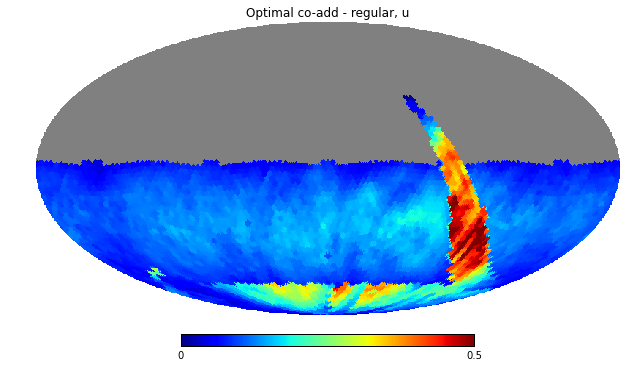

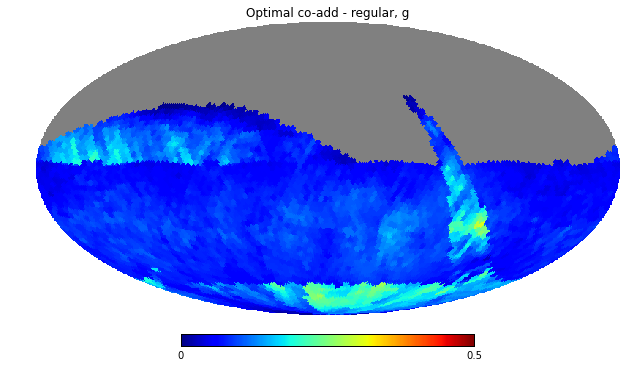

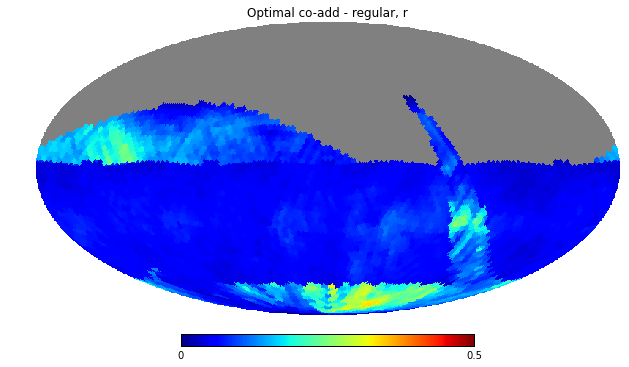

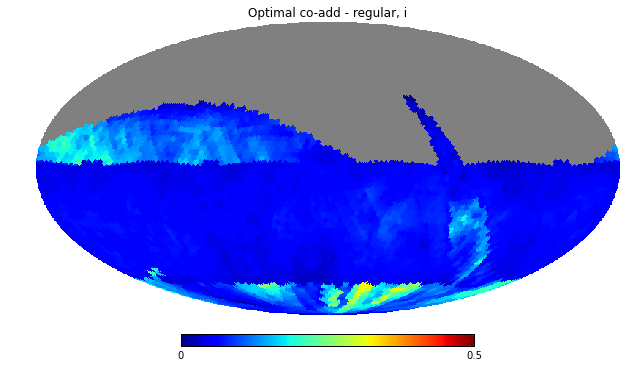

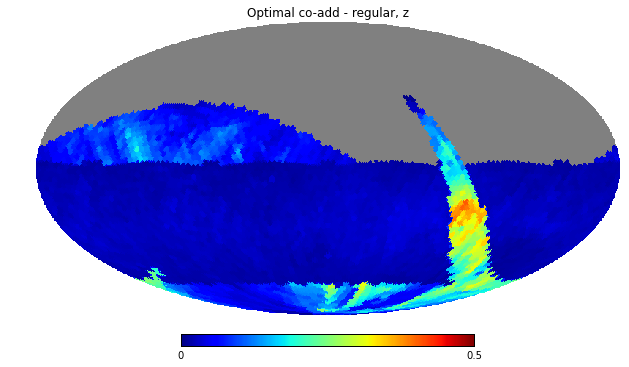

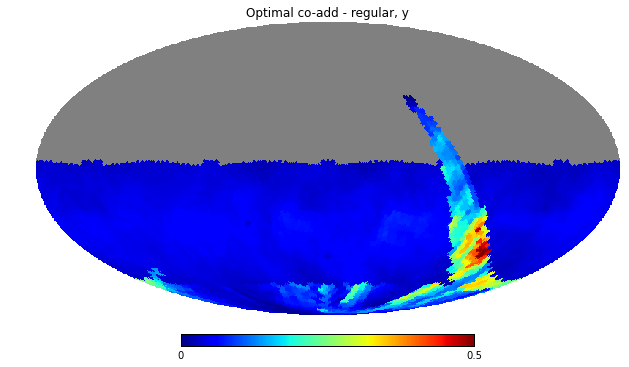

In [20]:
for i,filtername in enumerate(filters):
    newmap = bundleList[i*2+1].metricValues-bundleList[i*2].metricValues
    newmap[np.where(bundleList[i*2+1].metricValues.mask == True)] = hp.UNSEEN
    hp.mollview(newmap, 
                title='Optimal co-add - regular, %s' % filtername, min=0,max=.5)

In [19]:
print 'filter,  Optimal m5, Regular m5, diff'
for i,filtername in enumerate(filters):
    optimal = bundleList[i*2+1].summaryValues['Median']
    regular = bundleList[i*2].summaryValues['Median']
    print '%s, %.2f, %.2f, %.2f' % (filtername, optimal, regular, optimal-regular)

filter,  Optimal m5, Regular m5, diff
u, 25.57, 25.46, 0.12
g, 27.01, 26.93, 0.08
r, 27.13, 27.07, 0.06
i, 26.38, 26.32, 0.05
z, 25.20, 25.17, 0.03
y, 24.48, 24.43, 0.05
